In [1]:
# Imports

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error

# Data Preprosessing:

In [2]:
file_path = './orders_autumn_2020.csv'
df = pd.read_csv(file_path, delimiter=',')

# Selecting relevant features based on our problem
selected_features = ['TIMESTAMP', 'ACTUAL_DELIVERY_MINUTES', 'ESTIMATED_DELIVERY_MINUTES', 'ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES',
                     'CLOUD_COVERAGE', 'TEMPERATURE', 'WIND_SPEED', 'PRECIPITATION']

df = df[selected_features]

print("Dataset Information:")
print(df.info())

print("\nMissing Values:")
print(df.isnull().sum())

print("\nDuplicated Rows:")
print(df.duplicated().sum())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18706 entries, 0 to 18705
Data columns (total 8 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   TIMESTAMP                                             18706 non-null  object 
 1   ACTUAL_DELIVERY_MINUTES                               18706 non-null  int64  
 2   ESTIMATED_DELIVERY_MINUTES                            18706 non-null  int64  
 3   ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES  18706 non-null  int64  
 4   CLOUD_COVERAGE                                        18429 non-null  float64
 5   TEMPERATURE                                           18429 non-null  float64
 6   WIND_SPEED                                            18429 non-null  float64
 7   PRECIPITATION                                         18706 non-null  float64
dtypes: float64(4), int64(3), object(1)
m

In the above print lines we can see that we have 277 missing values in each feature CLOUD_COVERAGE, TEMPERATURE and WIND_SPEED. We need to check if they are from the same lines. If yes, we should remove those lines from the dataset because these features are key in prediction of Weather Impact on Delivery Times.

The last print line above says that there are 7 duplicated rows. Actually, these rows are not duplicated in the original data because after using only the selected features in the dataset, it just happens to be that we get 7 identical rows. I also checked this with the original dataset, and there were 0 duplicated rows.

In [3]:
all_missing_values_truth = df[['CLOUD_COVERAGE', 'TEMPERATURE', 'WIND_SPEED']].isnull().all(axis=1).any()
print("Are missing values from the same row?", all_missing_values_truth)


df = df.dropna(subset=['CLOUD_COVERAGE', 'TEMPERATURE', 'WIND_SPEED'], how='all')


Are missing values from the same row? True


# Feature Engineering:

The feature TIMESTAMP might not be directly used as a predictor in the task. However, the TIMESTAMP feature can be valuable for feature engineering. For example we can use TIMESTAMP for:
- Extract time related features
- Create interaction between time related features and weather features

In [4]:
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])

df['hour_of_day'] = df['TIMESTAMP'].dt.hour
df['day_of_week'] = df['TIMESTAMP'].dt.dayofweek

Creating interaction terms or combining weather features can be a useful to capture potential non linear relationships if they exist between these features.

In [5]:
df['temperature_precipitation_interaction'] = df['TEMPERATURE'] * df['PRECIPITATION']
df['temperature_wind_speed_interaction'] = df['TEMPERATURE'] * df['WIND_SPEED']
df['precipitation_wind_speed_interaction'] = df['PRECIPITATION'] * df['WIND_SPEED']

# Exploratory Data Analysis (EDA):

In [6]:
print(df.columns.tolist())

['TIMESTAMP', 'ACTUAL_DELIVERY_MINUTES', 'ESTIMATED_DELIVERY_MINUTES', 'ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES', 'CLOUD_COVERAGE', 'TEMPERATURE', 'WIND_SPEED', 'PRECIPITATION', 'hour_of_day', 'day_of_week', 'temperature_precipitation_interaction', 'temperature_wind_speed_interaction', 'precipitation_wind_speed_interaction']


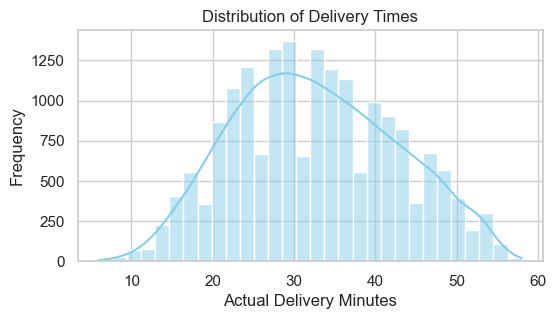

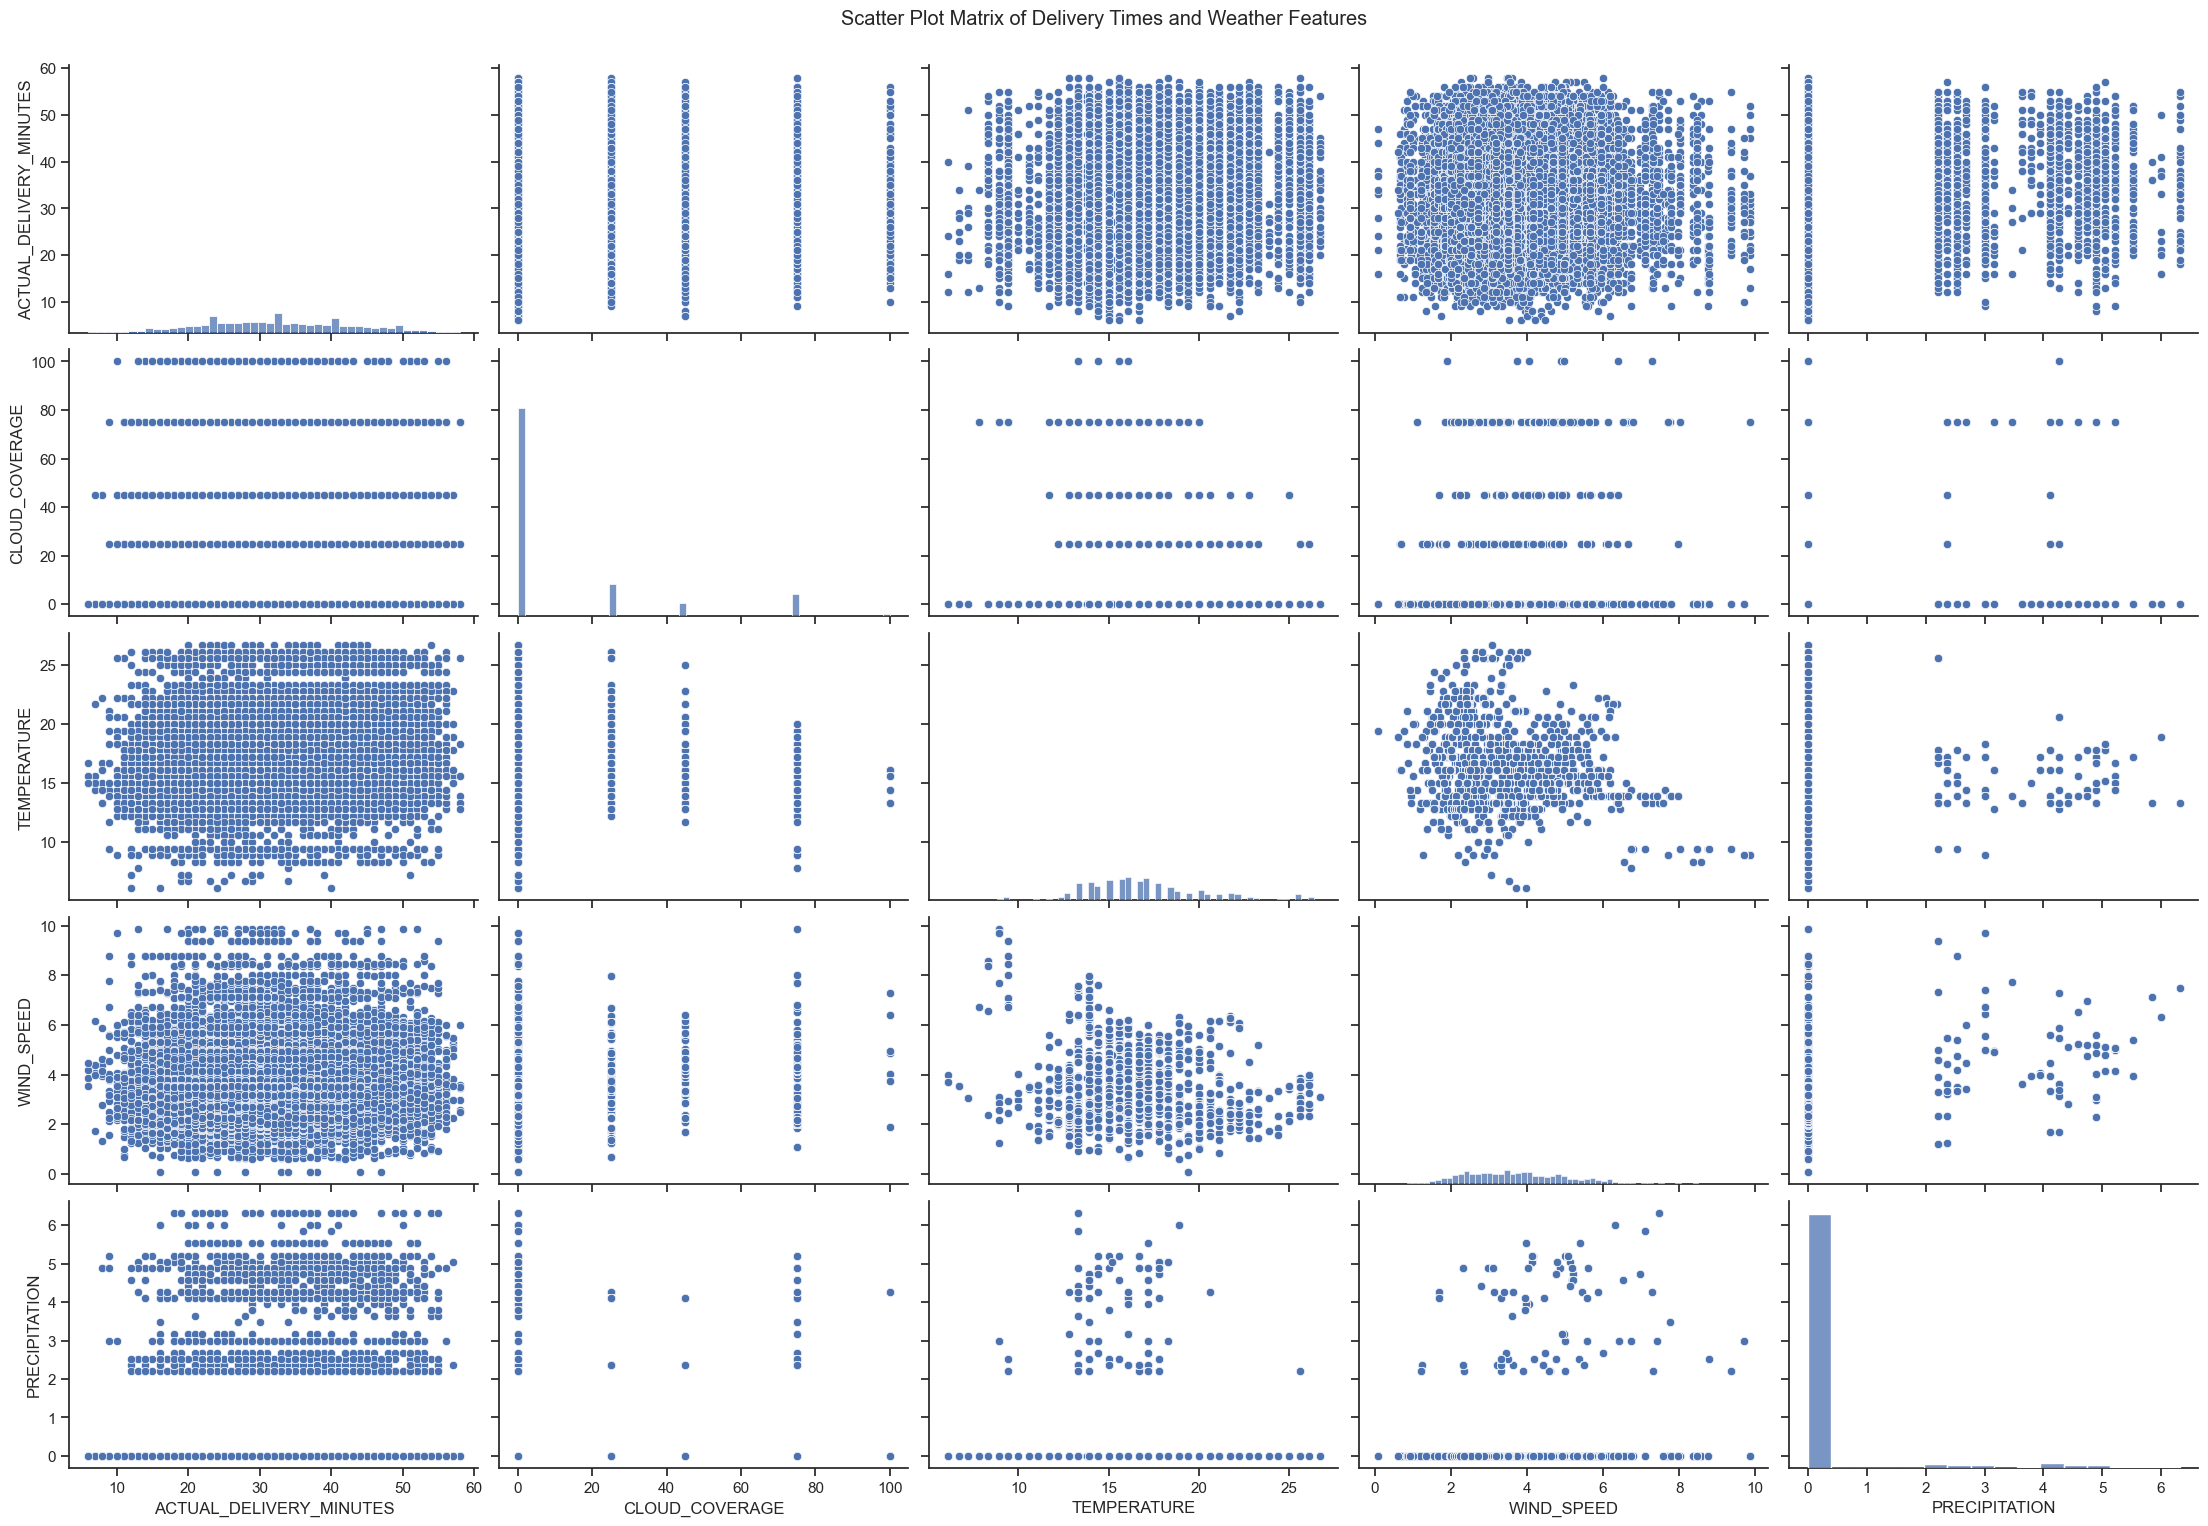

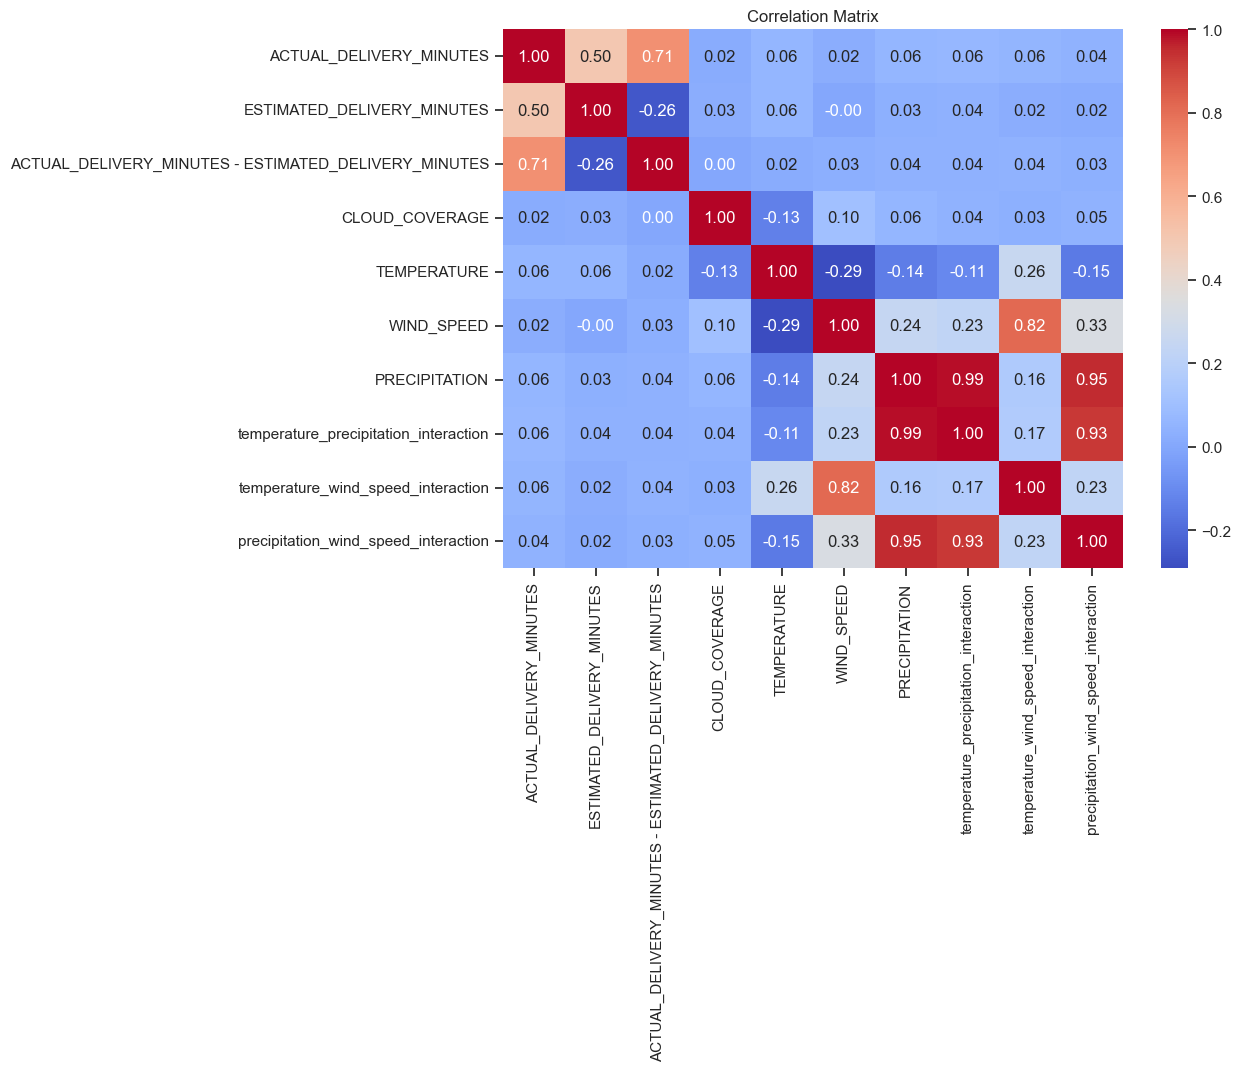

In [7]:
sns.set(style="whitegrid")

# Distribution of delivery times
plt.figure(figsize=(6, 3))
sns.histplot(df['ACTUAL_DELIVERY_MINUTES'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Delivery Times')
plt.xlabel('Actual Delivery Minutes')
plt.ylabel('Frequency')
plt.show()

# Trends in delivery times based on weather conditions
scatter_data = df[['ACTUAL_DELIVERY_MINUTES', 'CLOUD_COVERAGE', 'TEMPERATURE', 'WIND_SPEED', 'PRECIPITATION']]
sns.set(style="ticks")
scatter_plot = sns.pairplot(scatter_data, height=3, aspect=1.5, kind='scatter', markers="o")
plt.suptitle('Scatter Plot Matrix of Delivery Times and Weather Features', y=1.02)
plt.show()

# Correlations between weather variables and delivery times
correlation_matrix = df[['ACTUAL_DELIVERY_MINUTES', 'ESTIMATED_DELIVERY_MINUTES', 'ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES', 'CLOUD_COVERAGE', 'TEMPERATURE', 'WIND_SPEED', 'PRECIPITATION', 'temperature_precipitation_interaction', 'temperature_wind_speed_interaction', 'precipitation_wind_speed_interaction']].corr()

plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

- On average, it looks like deliveries are taking around 30 minutes, providing a good baseline understanding of our dataset

- The scatter plot for ACTUAL_DELIVERY_MINUTES doesn't reveal any clear trends when compared to CLOUD_COVERAGE, TEMPERATURE, WIND_SPEED, and PRECIPITATION. This suggests that these weather features might not have a straightforward linear relationship with delivery times

- It's not surprising to see high correlations between ACTUAL_DELIVERY_MINUTES, ESTIMATED_DELIVERY_MINUTES, and ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES — in correlations Matrix. Notably, the newly created interaction terms show correlations with the features they are derived from

- The correlation matrix doesn't show any significant correlation between delivery time features and weather condition features. This could be because the relationship between delivery times and weather conditions may involve more complexity, possibly non-linear patterns or other factors we haven't considered yet


# Model Building:

Given the size of our dataset, I believe that using cross-validation is a good choice. Cross-validation allows us to train and test our model on different data subsets and this provides a more reliable estimate of its performance.

Considering the insights from our analysis. It's obvious that the relationship between delivery times and weather conditions isn't straightforward. There seem to be non-linear patterns or other factors. I've opted for Random Forest as our machine learning model. It's known for its strength in handling non-linear relationships. This makes it a robust choice. Another advantage is its flexibility with numerical and categorical features.

We will use Random Forest that is an ensemble learning method that can handle non-linear relationships well. It's robust, doesn't require extensive feature scaling, and can handle a mix of numerical and categorical features.

In [8]:
X = df[['CLOUD_COVERAGE', 'TEMPERATURE', 'WIND_SPEED', 'PRECIPITATION', 
        'temperature_precipitation_interaction', 'temperature_wind_speed_interaction', 'precipitation_wind_speed_interaction']]
y = df['ACTUAL_DELIVERY_MINUTES']

model = RandomForestRegressor(n_estimators=100)

# Cross-validation
cv_scores_mae = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
cv_scores_mse = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_scores_r2 = cross_val_score(model, X, y, cv=5, scoring='r2')

# Scores to positive values
cv_scores_mae = -cv_scores_mae
cv_scores_mse = -cv_scores_mse

# MAPE
y_pred = model.fit(X, y).predict(X)
mape = np.mean(np.abs((y - y_pred) / y)) * 100

# Model Evaluation:

In [9]:
print("Cross-Validation Scores:")
print(f"MAE: {cv_scores_mae}")
print(f"MSE: {cv_scores_mse}")
print(f"R2 Score: {cv_scores_r2}")
print(f"MAPE: {mape}%")

# Mean scores
mean_mae = np.mean(cv_scores_mae)
mean_mse = np.mean(cv_scores_mse)
mean_r2 = np.mean(cv_scores_r2)

print(f"\nMean Absolute Error (MAE) across folds: {mean_mae}")
print(f"Mean Squared Error (MSE) across folds: {mean_mse}")
print(f"R2 Score across folds: {mean_r2}")
print(f"Mean Absolute Percentage Error (MAPE) across folds: {mape}%")

Cross-Validation Scores:
MAE: [8.83153914 8.79352163 9.21300916 8.54968727 8.15199403]
MSE: [116.97715889 117.31613314 130.8592177  109.16874967  99.66275875]
R2 Score: [-0.20749671 -0.18093201 -0.27720454 -0.08125128 -0.12016614]
MAPE: 25.90392894267722%

Mean Absolute Error (MAE) across folds: 8.707950246253393
Mean Squared Error (MSE) across folds: 114.79680363072148
R2 Score across folds: -0.17341013738449002
Mean Absolute Percentage Error (MAPE) across folds: 25.90392894267722%


Comparing the performance of ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES with ACTUAL_DELIVERY_MINUTES helps us to assess the effectiveness of using weather related features in predicting delivery times. The comparison helps us understand whether using weather conditions, as done in the model, contributes to the accuracy of delivery time predictions. If the ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES feature alone provides predictions that are more accurate than the model, it suggests that our model might not be good enough

There are likely other aspects in addition to only weather affecting the feature ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES

In [10]:
print("ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES evalution for comparison:\n")
y_actual_estimated = df['ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES']
y_actual = df['ACTUAL_DELIVERY_MINUTES']

mae = mean_absolute_error(y_actual, y_actual_estimated)
mse = mean_squared_error(y_actual, y_actual_estimated)
r2 = r2_score(y_actual, y_actual_estimated)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R2 Score: {r2}")

ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES evalution for comparison:

MAE: 33.833251939877364
MSE: 1198.7094796245049
R2 Score: -10.93730083546067


# Results Interpretation:

Mean Absolute Error (MAE):

- The MAE scores reveal that, across the five folds, our model predicts delivery times with errors ranging from approximately 8.51 to 9.21 minutes.
- The overall mean MAE across folds is around 8.72 minutes.

Mean Squared Error (MSE):

- MSE scores provide a measure of the spread of prediction errors. In this case, the model's predictions range from approximately 99.42 to 130.51 in terms of squared errors.
- The mean MSE across folds is about 114.49.

R2 Score:

- R2 scores are negative across all folds, indicating suboptimal model performance. A mean R2 score of approximately -0.17 suggests that the model falls short of capturing the variance in the data, performing less effectively than a model predicting the mean of the target variable.

Mean Absolute Percentage Error (MAPE):

- The MAPE, a percentage measure of prediction accuracy, highlights that, on average, our model's predictions deviate by around 25.89% from the actual delivery times.

Analysis:

- The MAE and MSE metrics shed light on the average magnitude and spread of prediction errors. Our model, on average, predicts delivery times with an error of about 8.72 minutes.

- The negative R2 scores hint at a challenge in explaining the variance in delivery times. This complexity may arise from the intricate relationship between delivery times and weather conditions.

- The MAPE underscores the model's average percentage deviation in predictions from actual delivery times, emphasizing a deviation of about 25.89%.

Comparison with the feature 'ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES':

- The performance metrics indicate that our model, based on weather conditions, performs significantly better than the model relying on the feature ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES

Feature importance:

- Random Forest operates by combining multiple decision trees, and the contributions of each feature are distributed across these trees. Instead of interpreting coefficients, Random Forest models offer feature importance scores. Visualizing feature importance scores can helps us understand which features are contributing the most to the model's predictions.

Feature Importance:
                                 Feature  Importance
5     temperature_wind_speed_interaction    0.375796
2                             WIND_SPEED    0.372372
1                            TEMPERATURE    0.135142
0                         CLOUD_COVERAGE    0.059353
4  temperature_precipitation_interaction    0.025625
6   precipitation_wind_speed_interaction    0.022455
3                          PRECIPITATION    0.009258


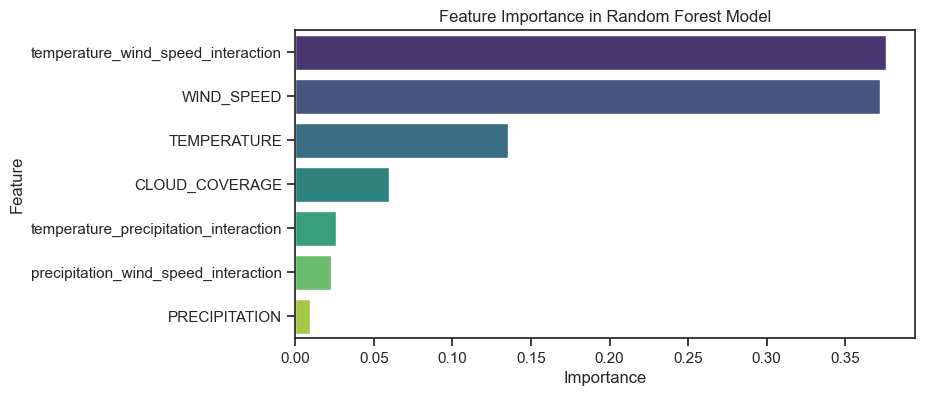

In [11]:
feature_importance = model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importance:")
print(feature_importance_df)

plt.figure(figsize=(8, 4))
sns.barplot(x='Importance', y='Feature', hue='Feature', data=feature_importance_df, palette='viridis', legend=False)
plt.title('Feature Importance in Random Forest Model')
plt.show()

- Wind speed is the most critical factor, significantly affecting delivery times
- The interaction between temperature and wind speed also plays a substantial role, indicating a more nuanced relationship

- Temperature, while important, has a moderate impact compared to wind speed
- Cloud coverage contributes but to a lesser extent, suggesting its influence is not as pronounced

- Interactions involving precipitation and temperature, as well as precipitation and wind speed, have minor impacts
- Precipitation alone has the least influence on delivery times

# Evaluation & Further development

Evalution

The results obtained from the model are reasonably satisfactory. The Mean Absolute Error (MAE) shows that, on average, the model predicts delivery times within approximately 8.73 minutes of the actual values. While there is room for improvement, the model provides a decent baseline for predicting delivery times based on weather conditions.

Expectations in Production
In a production environment, we would anticipate more nuanced results as the model encounters diverse real-world scenarios. It's crucial to monitor its performance over time and make necessary adjustments based on new data.

Further Development
To enhance the model, one could explore subtle adjustments or even consider alternative methods. Comparing the two models, the one incorporating weather conditions exhibits notable strengths in accuracy, with lower MAE and MSE compared to the model relying on the difference between actual and estimated delivery times.

Future Development
Given more time and resources, additional features or more sophisticated modeling techniques could be explored. Fine-tuning hyperparameters, incorporating more weather variables, or even experimenting with different machine learning algorithms could contribute to a more robust and accurate solution.

In summary, while the current model provides a decent prediction foundation, continuous monitoring and iterative improvements are essential for adapting to the dynamic nature of delivery data.